In [4]:
import numpy as np
from ler.rates import LeR
import json
import matplotlib.pyplot as plt
%matplotlib inline  

## Velocity dispersion

In [ ]:
def phi_hyd(sigmal, zl):
    

In [2]:
ler = LeR(interpolator_dir="../interpolator_pickle")

Given: IMR waveform, {self.waveform_approximant}.
psds not given. Choosing bilby's default psds
given psds:  {'L1': 'aLIGO_O4_high_asd.txt', 'H1': 'aLIGO_O4_high_asd.txt', 'V1': 'AdV_asd.txt'}
Interpolator will be loaded for L1 detector from ../interpolator_pickle/L1/halfSNR_dict_0.pickle
Interpolator will be loaded for H1 detector from ../interpolator_pickle/H1/halfSNR_dict_0.pickle
Interpolator will be loaded for V1 detector from ../interpolator_pickle/V1/halfSNR_dict_0.pickle


In [3]:
# generating lensed events with SIS optical depth
ler.batch_size = 10000
ler.lensed_cbc_statistics(nsamples=10000);

chosen batch size = 10000. If you want to change batch size, self.batch_size = new_size
There will be 1 batche(s)
Batch no. 1
sampling lensed params...
solving lens equations...


100%|███████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4512.02it/s]


calculating snrs...


In [4]:
from scipy.interpolate import interp1d

# from https://git.ligo.org/anupreeta.more/o4_sims/-/blob/main/srclensprop.py#L212
def init_crosssect():
    global cross_sect_spl;
    # print("## Initializing Cross-section")
    qi,csecti=np.loadtxt("Crosssect.dat",unpack=1)
    cross_sect_spl=interp1d(qi,csecti,kind='cubic')

init_crosssect()
cross_sect_spl(0.99)

array(317.32724912)

### with random velocity dispersion and axis ratio

In [20]:
# from https://git.ligo.org/anupreeta.more/o4_sims/-/blob/main/srclensprop.py#L229
def strong_lensing_optical_depth_SIE(zs):
    """
    Function to compute the strong lensing optical depth SIE

    Parameters
    ----------
        zs : `float`
            source redshifts

    Returns
    -------
        tau : `float`
            strong lensing optical depth

    """
    # for SIE model
    # define a function to calculate the cross section number
    # here we already assume that we have initialized the crossection spline
    # from https://git.ligo.org/anupreeta.more/o4_sims/-/blob/main/srclensprop.py#L219 
    def getcrosssect_num(theta_E, q):
        fid_b_I = 10.0  # constant
        idx = q > 0.999
        q[idx] = 0.999
        idx = q < 0.1
        q[idx] = 0.1
        b_I = theta_E * np.sqrt(q)
        return cross_sect_spl(q)*(b_I/fid_b_I)**2

    # theta_E=bsis=einstein_radius_SIS  # refer to compute_einstein_radii
    # q=axis_ratio_SIE
    sigma, q = ler.lens_galaxy_pop.sample_velocity_dispersion_axis_ratio(zs)
    zl = ler.lens_galaxy_pop.sample_lens_redshifts(zs)
    theta_E = ler.lens_galaxy_pop.compute_einstein_radii(sigma, zl, zs)
    
    tau = getcrosssect_num(theta_E, q)/(4*np.pi)
    
    return tau, theta_E, sigma, q, zl

In [21]:
z_max = 10.0
z = np.linspace(0.0, z_max, 500)
tau, theta_E, sigma, q, zl = strong_lensing_optical_depth_SIE(zs=z)

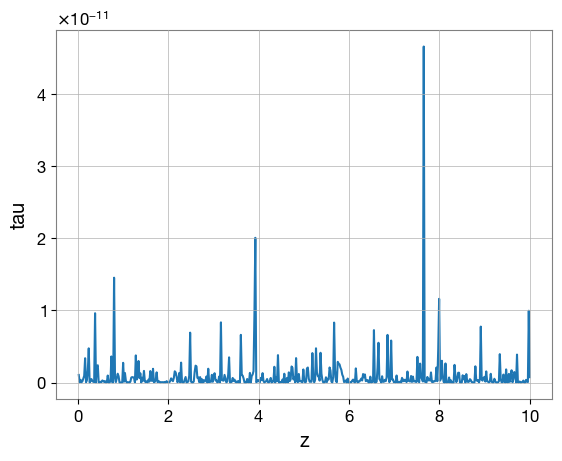

In [22]:
# plot z vs tau
plt.plot(z, tau)
plt.xlabel("z")
plt.ylabel("tau")
plt.show()

In [ ]:
# 

## SIS

In [13]:
# SIS model
tau_sis = ler.lens_galaxy_pop.strong_lensing_optical_depth_SIS(zs=z)

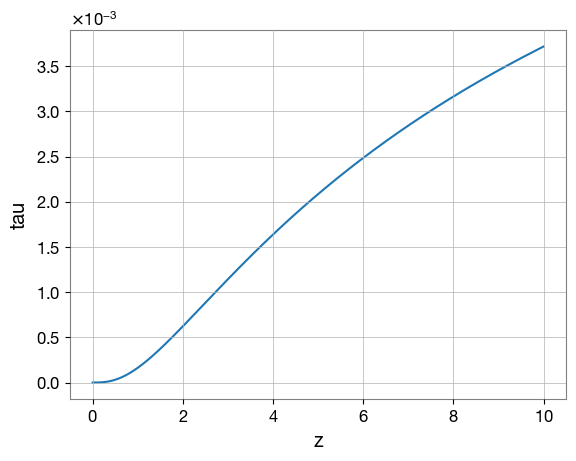

In [14]:
# plot z vs tau
plt.plot(z, tau_sis, label="SIS")
plt.xlabel("z")
plt.ylabel("tau")
plt.show()

### with averaging over velocity dispersion, axis ratio, zlens

* we need to find the normalizing factor, which in given here https://ler.readthedocs.io/en/latest/lensed.html
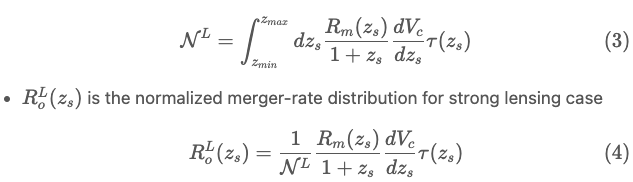

* if we consider optical_depth(zs) as a function of zs, then we have to sample over zlens, sigma, axis_ratio and average out.
* the problem is optical_depth(zs) is not a smooth function of zs. And the value is very small, at the order of 1e-11 as compared to 1e-3 for SIS.

In [41]:
# from https://git.ligo.org/anupreeta.more/o4_sims/-/blob/main/srclensprop.py#L229
def strong_lensing_optical_depth_SIE(zs):
    """
    Function to compute the strong lensing optical depth SIE

    Parameters
    ----------
        zs : `float`
            source redshifts

    Returns
    -------
        tau : `float`
            strong lensing optical depth

    """
    # for SIE model
    # dedine a function to calculate the cross section number
    # here we already assume that we have initialized the crossection spline
    # from https://git.ligo.org/anupreeta.more/o4_sims/-/blob/main/srclensprop.py#L219 
    def getcrosssect_num(theta_E, q):
        fid_b_I = 10.0  # constant
        idx = q > 0.999
        q[idx] = 0.999
        idx = q < 0.1
        q[idx] = 0.1
        b_I = theta_E * np.sqrt(q)
        return cross_sect_spl(q)*(b_I/fid_b_I)**2

    # theta_E=bsis=einstein_radius_SIS  # refer to compute_einstein_radii
    # q=axis_ratio_SIE
    size = np.size(zs)
    tau = np.zeros(size)
    
    # average out in for each source redshift
    for i in range(size):
        z = zs[i]*np.ones(1000)
        sigma, q = ler.lens_galaxy_pop.sample_velocity_dispersion_axis_ratio(z)
        zl = ler.lens_galaxy_pop.sample_lens_redshifts(z)
        theta_E = ler.lens_galaxy_pop.compute_einstein_radii(sigma, zl, z)
    
        tau[i] = np.average(getcrosssect_num(theta_E, q)/(4*np.pi))
    
    return tau

In [42]:
z_max = 10.0
z = np.linspace(0.0, z_max, 500)
tau = strong_lensing_optical_depth_SIE(zs=z)

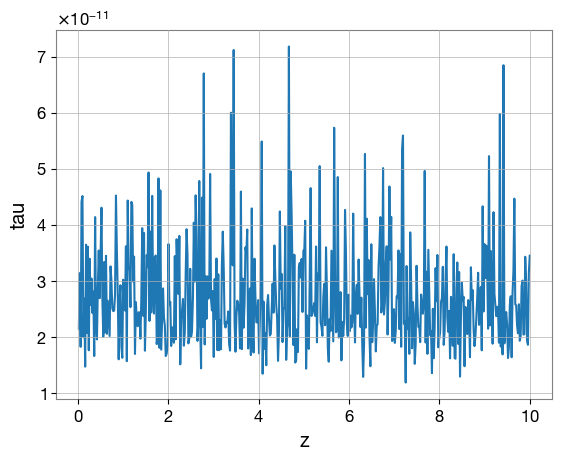

In [43]:
# plot z vs tau
plt.plot(z, tau)
plt.xlabel("z")
plt.ylabel("tau")
plt.show()

In [6]:
fid_b_I=10.0

def getcrosssect_num(q,bsis=1):
    global cross_sect_spl,init_cs_spl;
    if(init_cs_spl==0):
      init_crosssect();
    b_I=bsis*np.sqrt(q);
    return cross_sect_spl(q)*(b_I/fid_b_I)**2;

q = np.linspace(0.1, 0.999, 500)
tau = getcrosssect_num(q=q)


NameError: name 'init_cs_spl' is not defined

In [ ]:
# plot z vs tau
